# Temperature forcing

This notebook aims at giving the correct temperature forcing to the compaction model, based on meteorological data.

## Imports and functions

In [58]:
%run little_awk_functions.py      # Attention c'est un doublon for now


## Define data

In [45]:
# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

all_data_set = None

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1.nc')
data_pit_1 = xr.open_dataset('snow_pit_1.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2.nc')
data_pit_2 = xr.open_dataset('snow_pit_2.nc')

# Define which dataset to use in what follows

data_set_used = data_pit_2
# data_set_used

In [54]:
# Pre-processing to get clean data

# if data_set_used == all_data_set:
    # fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
# if data_set_used == all_data_set:
    # median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - 0.27698712 - 0.41428454 + 0.22014742  # TODO modular


---> Median filtering in space with a window [7, 11]


In [38]:
# Meteorological data

met_time_data, met_temp_data = get_met_forcing()


## Define parameters

In [47]:
# Defining parameters for snow events detection

x_sel = 20
y_sel = 20
time_window_std = 25
std_threshold = 0.015

data_starting_date_in_ns = 1638796500000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb
# 1625149800000000000 is the first time point in all_data_set (2021-07-01-16:30)
# 1638316800000000000 is the first time point in the snowpit datasets
# 1630454400000000000 is the first time point in Crocus

In [48]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -5  # eyeballed mean of temperatures
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 20
nb_iterations = 70000     # TODO adapt to duration of data

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0
ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))


## Compute and plot

In [49]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


/tmp/ipykernel_7741/140324894.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


In [55]:
# Update variables at each timepoint

ro_layer_evolution_temp, depth_evolution_temp, temperature_evolution_temp = simulate_snowpack_evolution_temp(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, dy_snow, gamma, cp_snow, melt_flag,
                                                                                        a1, a2, met_temp_data, met_time_data)

ro_layer_evolution, depth_evolution, temperature_evolution = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag,
                                                                                        a1, a2)


()

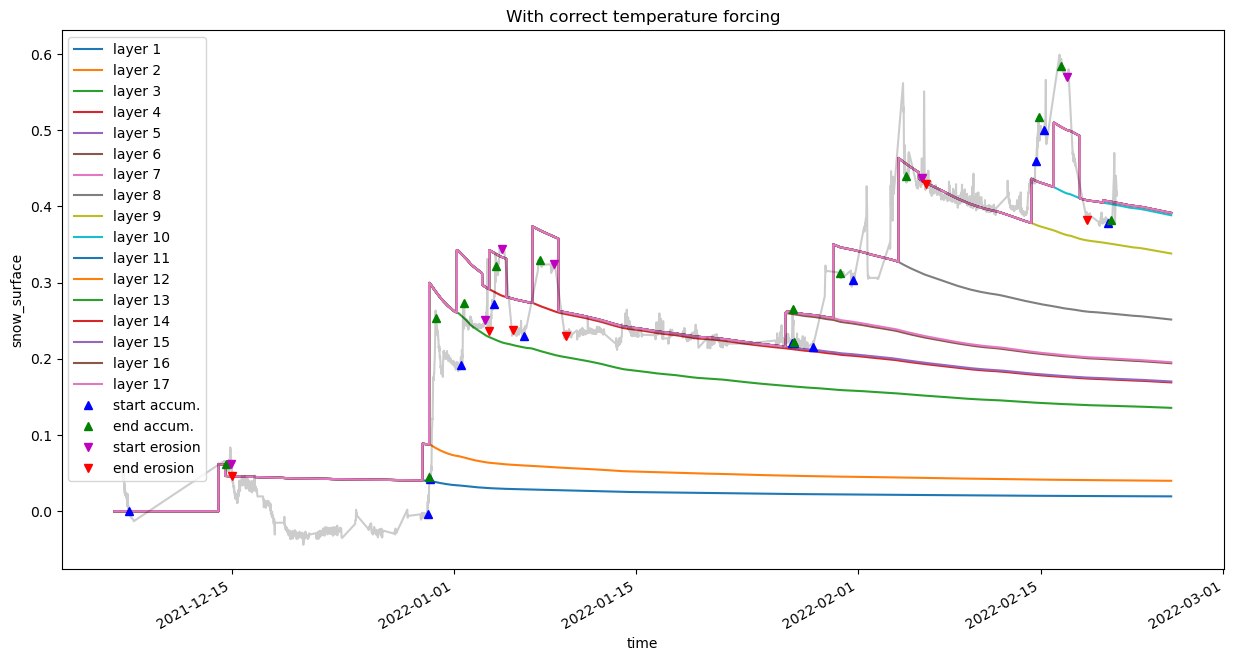

In [56]:
data_start_date = pd.to_datetime('2021-12-06T00:00')

plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution_temp, 17, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                     save_file=False, my_file_name='correct_temp_forcing_pi.png', my_title='With correct temperature forcing')

()

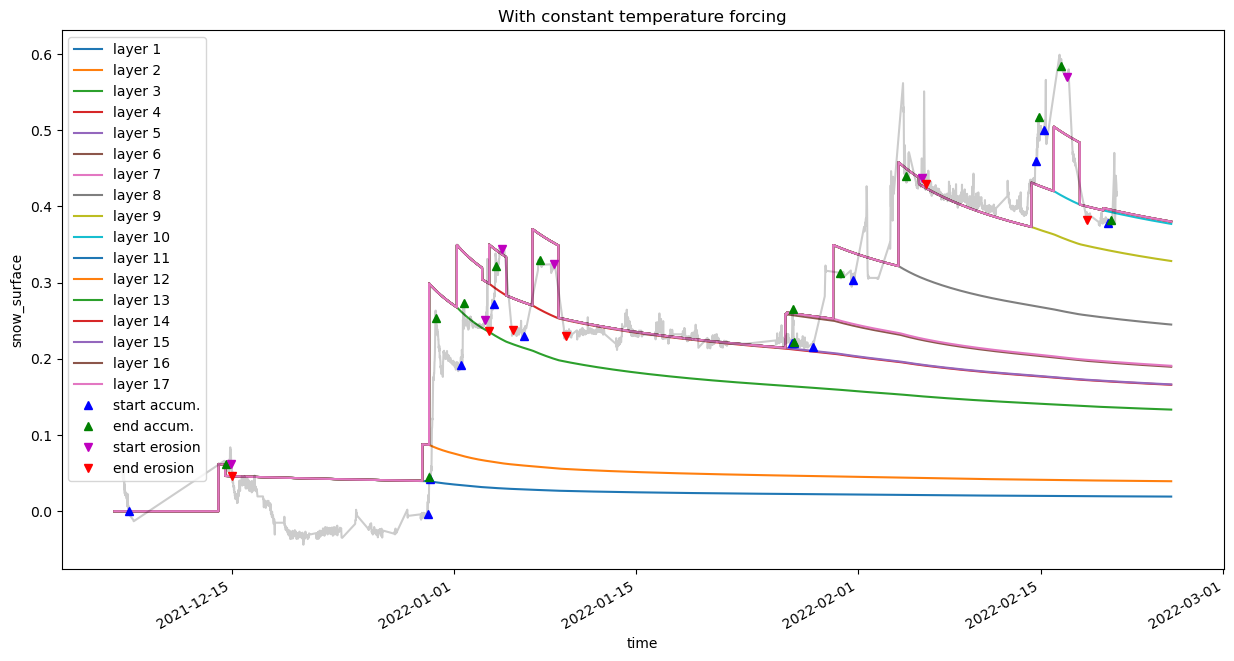

In [57]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 17, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                     save_file=False, my_file_name='no_temp_forcing_pi.png', my_title='With constant temperature forcing')

In [53]:
data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0])

<xarray.DataArray 'snow_surface' ()>
array(-0.22014742)
Coordinates:
    time     datetime64[ns] 2021-12-07T02:15:00
    x        float64 -7.45
    y        float64 -1.35